# Label classifier (dSprites): data collection

## Task 1

**Author**: Maleakhi A. Wijaya  
**Description**: This notebook contains code used to collect experimentation data. We compare the performance of methods discussed in Rabanset et al. against our proposed CBSD method. The end-to-end task for task 1 is to predict the shape given sprites as inputs.

In [1]:
# Load utilities functions
%run ../../scripts/constants.py
%run ../../scripts/dsprites_utils.py
%run ../../scripts/shift_applicator.py
%run ../../scripts/shift_dimensionality_reductor.py
%run ../../scripts/experiment_utils.py
%run ../../scripts/shift_statistical_test.py

In [2]:
## Random seed
SEED = 20
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load dataset

In [ ]:
path = "../../data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
X_train, X_test, y_train, y_test, c_train, c_test = load_dsprites(path, 100000, DatasetTask.Task1, train_size=0.85, class_index=1)
n_classes_shape = 3
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
concept_values = get_latent_sizes()

# Split training into validation set as well 
X_train, X_valid = X_train[:70000], X_train[70000:]
y_train, y_valid = y_train[:70000], y_train[70000:]
c_train, c_valid = c_train[:70000], c_train[70000:]

In [4]:
# Reshape to appropriate shift input
# It is noteworthy that for efficiency, we represent the images as only 2 dimension
# when we preprocessing (number of instances/ batch size * flatten size).
# When visualising back the image, we need to reshape it back to the original dimension
ORIGINAL_SHAPE = X_test.shape[1:] # constant hold the image original shape
X_test_flatten = deepcopy(X_test.reshape(X_test.shape[0], -1))
X_train_flatten = deepcopy(X_train.reshape(X_train.shape[0], -1))
X_valid_flatten = deepcopy(X_valid.reshape(X_valid.shape[0], -1))

## Dimensionality reduction

We implemented various dimensionality reduction methods, amounting to:
- End to end model (label classifiers/ BBSD)
- Concept bottleneck model (CBSD)
- Trained and untrained autoencoders (TAE and UAE)
- Principal component analysis (PCA)
- Sparse random projection (SRP)

### End-to-end model

In [7]:
path = "../../models/end_to_end_dsprites_task1"
# For training and saving
# histories, end_to_end_model = end_to_end_neural_network(n_classes_shape, Dataset.DSPRITES, 
#                          X_train, y_train, X_valid, y_valid,
#                          path)

# For loading
end_to_end_model = tf.keras.models.load_model(path)

In [8]:
# Evaluate model
y_pred = end_to_end_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5091
           1       1.00      1.00      1.00      5017
           2       1.00      1.00      1.00      4892

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



### Concept bottleneck model

**Input to Concept**

In [5]:
path = "../../models/multitask_dsprites"
# For training and saving
# histories, mt_model = multitask_model(Dataset.DSPRITES,
#                                             X_train, c_train,
#                                             X_valid, c_valid)

# For loading
mt_model = tf.keras.models.load_model(path)

In [6]:
# Evaluate model
for i, pred in enumerate(mt_model.predict(X_test)):
    print("*"*20, f"Model: {DSPRITES_CONCEPT_NAMES[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(pred, axis=1)
    
    print(classification_report(c_truth, c_pred))
    print("\n\n")

******************** Model: color ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000




******************** Model: shape ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5091
           1       1.00      1.00      1.00      5017
           2       1.00      1.00      1.00      4892

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000




******************** Model: scale ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2476
           1       1.00      1.00      1.00      2536
           2

**Concept to Output**

In [24]:
# Build and train model. For simplicity, we used logistic regression
# although can be substituted using other model.
com = LogisticRegression()
com.fit(c_train, y_train)

LogisticRegression()

In [25]:
y_test_pred = com.predict(c_test)
print(classification_report(y_test_pred, y_test))
print(confusion_matrix(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5091
           1       1.00      1.00      1.00      5017
           2       1.00      1.00      1.00      4892

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

[[5091    0    0]
 [   0 5017    0]
 [   0    0 4892]]


### Principal component analysis

In [5]:
pca, n_components = principal_components_analysis(X_train_flatten)
print(f"The number of components to explain 80% of variance is {n_components}.")

The number of components to explain 80% of variance is 42.


### Sparse random projection

In [12]:
srp, n_components = sparse_random_projection(X_train_flatten)
print(f"The number of components to explain 80% of variance is {n_components}.")

The number of components to explain 80% of variance is 42.


### Autoencoder

In [13]:
# The following are path to untrained and trained autoencoders
# (only the encoder)
path_uae = "../../models/uae_dsprites"
path_tae = "../../models/tae_dsprites"

# (both encoder and decoder)
path_full_uae = "../../models/uae_full_dsprites"
path_full_tae = "../../models/tae_full_dsprites"

# Train and save untrained autoencoder
# u_encoder, u_autoenc = autoencoder(Dataset.DSPRITES, 
#                                    X_train_flatten, X_valid_flatten,
#                                   ORIGINAL_SHAPE, train=False)
# u_encoder.save(path_uae)
# u_autoenc.save(path_full_uae)

# Train and save trained autoencoder
# encoder, autoenc = autoencoder(Dataset.DSPRITES,
#                                X_train_flatten, X_valid_flatten,
#                               ORIGINAL_SHAPE, train=True)
# encoder.save(path_tae)
# autoenc.save(path_full_tae)

## For loading
u_encoder = tf.keras.models.load_model(path_uae)
u_autoenc = tf.keras.models.load_model(path_full_uae)

encoder = tf.keras.models.load_model(path_tae)
autoenc = tf.keras.models.load_model(path_full_tae)

Trained AE


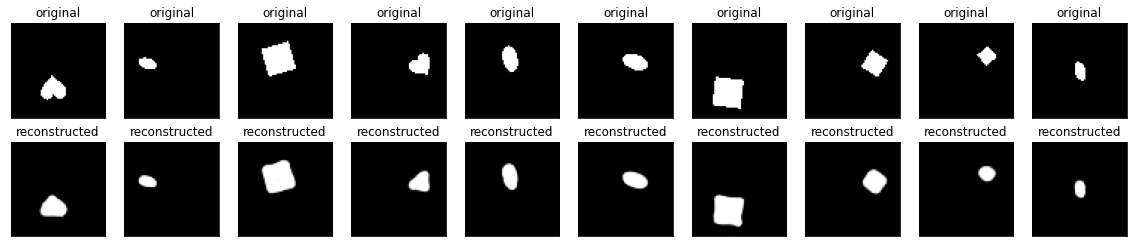


Untrained AE


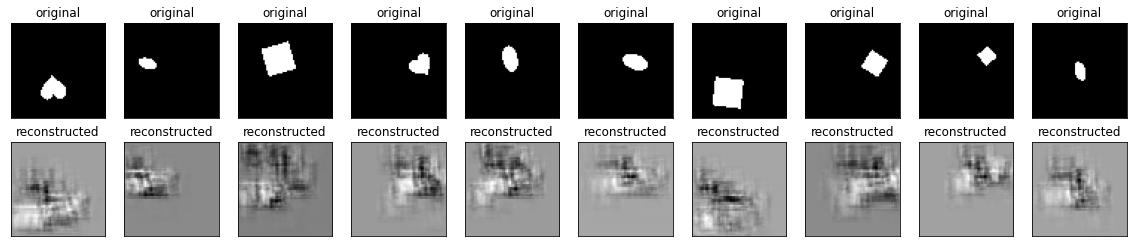

In [27]:
# Visualise results
# Trained autoencoder
print("Trained AE")
verify_autoencoder(autoenc, X_test)

print("\nUntrained AE")
verify_autoencoder(u_autoenc, X_test)

## Data collection

This section performs various experiments to collect data. We consider various dimensionality reduced methods discussed in the paper and thesis.

### PCA

In [6]:
method = DimensionalityReductor.PCA
model = pca
method_str = "PCA"

#### Knockout shift

In [7]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [8]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=5)

In [9]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

We consider the following concept shift combinations:
- scale
- scale + shape
- position x
- position y
- position x + position y
- position x + position y + scale

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

We consider the following image shifts:
- translation (x)
- translation (y)
- rotation
- shear
- zoom
- all (combination of image shifts)

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)

### SRP

In [36]:
method = DimensionalityReductor.SRP
model = srp
method_str = "SRP"

#### Knockout shift

In [6]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [7]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=1)

In [27]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)

### BBSDs

In [36]:
method = DimensionalityReductor.BBSDs
model = end_to_end_model
method_str = "BBSDs"

#### Knockout shift

In [6]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [6]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=1)

In [27]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)

### BBSDh

In [36]:
method = DimensionalityReductor.BBSDh
model = end_to_end_model
method_str = "BBSDh"

#### Knockout shift

In [6]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [5]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=1)

In [27]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)

### CBSDs

In [36]:
method = DimensionalityReductor.CBSDs
model = mt_model
method_str = "CBSDs"

#### Knockout shift

In [6]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [4]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=1)

In [27]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)

### CBSDh

In [36]:
method = DimensionalityReductor.CBSDh
model = mt_model
method_str = "CBSDh"

#### Knockout shift

In [6]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [1]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=1)

In [27]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)

### UAE

In [36]:
method = DimensionalityReductor.UAE
model = u_encoder
method_str = "UAE"

#### Knockout shift

In [6]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [2]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=1)

In [27]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)

### TAE

In [36]:
method = DimensionalityReductor.TAE
model = encoder
method_str = "TAE"

#### Knockout shift

In [6]:
shift_type = ShiftType.Knockout
shift_type_params = {"cl": MAJORITY}
shift_str = "ko"

In [3]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=1)

In [27]:
# Save file
save_result(shift_str, method_str, dict_result)

Saving successfully.


#### Concept shifts

In [ ]:
shift_type = ShiftType.Concept

list_shift_str = [
    "scale",
    "scale_shape",
    "x",
    "y",
    "x_y",
    "x_y_scale"
]

list_shift_type_params = [
    {"cl": MAJORITY, "concept_idx": 2}, # scale is index 2 in the concept names
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 1}],
    {"cl": MAJORITY, "concept_idx": 4},
    {"cl": MAJORITY, "concept_idx": 5},
    [{"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],
    [{"cl": MAJORITY, "concept_idx": 2}, {"cl": MAJORITY, "concept_idx": 4}, {"cl": MAJORITY, "concept_idx": 5}],    
]

In [ ]:
for shift_str, shift_type_params in tqdm(zip(list_shift_str, list_shift_type_params)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=100, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Image shifts

In [ ]:
list_shift = [
    ShiftType.Width,
    ShiftType.Height,
    ShiftType.Rotation,
    ShiftType.Shear,
    ShiftType.Zoom,
    ShiftType.All
]

list_shift_str = [
    "img_x",
    "img_x_y",
    "rotation",
    "shear",
    "zoom",
    "all"
]

shift_type_param = {"orig_dims": ORIGINAL_SHAPE}

In [ ]:
for shift_str, shift_type in tqdm(zip(list_shift_str, list_shift)):
    dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_param, n_exp=50, n_std=2)
    
    # Save
    save_result(shift_str, method_str, dict_result)

#### Gaussian shift

In [ ]:
shift_type = ShiftType.Gaussian
shift_type_params = None
shift_str = "gaussian"

In [ ]:
dict_result = main_experiment(model, method, X_valid, y_valid,
                             c_valid, X_test_flatten, y_test, c_test,
                             shift_type, ORIGINAL_SHAPE, n_classes_shape,
                             concept_names, concept_values, 
                             shift_type_params, n_exp=50, n_std=2)

In [ ]:
# Save file
save_result(shift_str, method_str, dict_result)